In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Lettura dati

In [3]:
df = pd.read_csv('data.txt')

In [4]:
df.head()

,Var1,Var2,Var3
0,-1,22.04,85.0
1,-1,33.85,82.0
2,-1,38.11,100.0
3,-1,39.95,78.0
4,-1,41.27,56.7


Var1 = percentuale delle immagini:

-1 vuol dire che la percentuale di immagini disponibili per quell’individuo è inferiore al 3.5  
+1 vuol dire che la percentuale di immagini disponibili per quell’individuo è superiore al 3.5  

Var2 = piqe mediano calcolato sulle immagini disponibile per ogni individuo 

Var3 = sensitività associata all’immagine 

<img src='./Quality scale of PIQE.png'></img>

In [5]:
df.columns = ('percentual', 'piqe_val', 'sensitivity')

In [6]:
def score2piqe(score):
    if (score > 80):
        return 'Bad'
    if (score > 50):
        return 'Poor'
    if (score > 35):
        return 'Fair'
    if (score > 20):
        return 'Good'
    return 'Excellent'

In [7]:
df['piqe'] = df['piqe_val'].apply(score2piqe)

In [8]:
df.head()

,percentual,piqe_val,sensitivity,piqe
0,-1,22.04,85.0,Good
1,-1,33.85,82.0,Good
2,-1,38.11,100.0,Fair
3,-1,39.95,78.0,Fair
4,-1,41.27,56.7,Fair


# Analisi preliminare

C:\Users\mark\.conda\envs\P3DSML\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


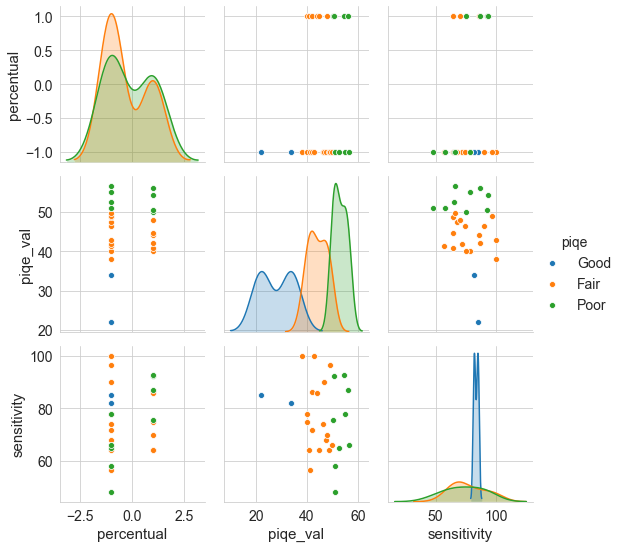

In [9]:
sns.pairplot(df, hue='piqe')

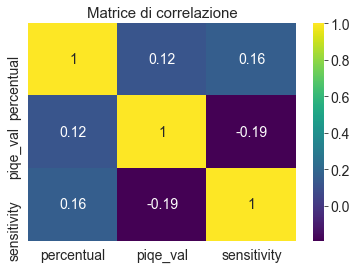

In [10]:
plt.title('Matrice di correlazione')
sns.heatmap(df.corr(), cmap='viridis', annot=True)

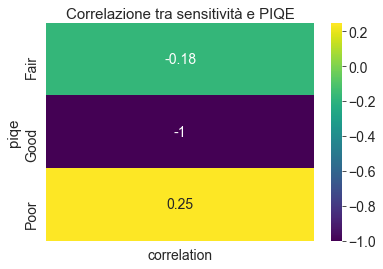

In [11]:
dfh = pd.DataFrame(df.groupby('piqe').corr().xs('sensitivity', level=1)['piqe_val'])
dfh.columns = {'correlation'}
plt.title('Correlazione tra sensitività e PIQE')
sns.heatmap(dfh, cmap='viridis', annot=True)

Le relazioni lineari sono piuttosto deboli... proviamo a farle lo stesso...

# Rette di regressione

Partiamo da dove dobbiamo arrivare, le rette di regressioni. Ricordiamo le formule:

$$cov_{x,y}=\frac{\sum_{i=1}^{N}(x_{i}-\bar{x})(y_{i}-\bar{y})}{N}$$

$$\sigma^2_{x} = \frac{\displaystyle\sum_{i=1}^{n}(x_i - \mu)^2} {n}$$

$$\sigma_{x} = \sqrt{\frac{\displaystyle\sum_{i=1}^{n}(x_i - \mu)^2} {n}}$$

## Con seaborn

Questo è il risultato a cui bisogna arrivare, ma come ci si arriva senza una funzione così comoda?

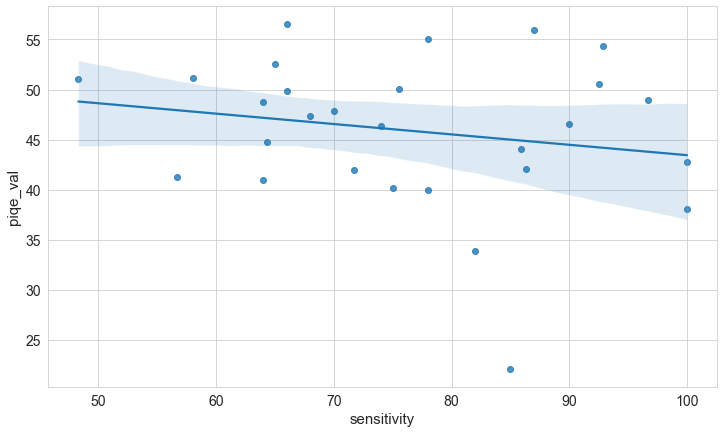

In [12]:
plt.figure(figsize=(12,7))
sns.regplot(data=df, x='sensitivity', y='piqe_val')

C:\Users\mark\.conda\envs\P3DSML\lib\site-packages\seaborn\regression.py:573: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


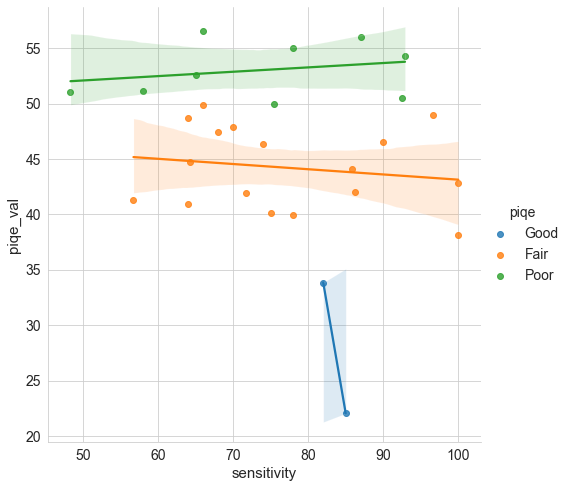

In [13]:
sns.lmplot(data=df, x='sensitivity', y='piqe_val', hue='piqe', size=7)

## A mano

Lo facciamo solo per il primo gruppo: "fair"

In [14]:
# Splittiamo le diverse classi di piqe in tanti dataframe
dfs = [x for _, x in df.groupby('piqe')]

In [15]:
dfs[0]

,percentual,piqe_val,sensitivity,piqe
2,-1,38.11,100.0,Fair
3,-1,39.95,78.0,Fair
4,-1,41.27,56.7,Fair
5,-1,41.92,71.7,Fair
6,-1,42.80,100.0,Fair
7,-1,46.34,74.0,Fair
8,-1,46.55,90.0,Fair
9,-1,47.40,68.0,Fair
10,-1,48.73,64.0,Fair
11,-1,48.94,96.7,Fair


In [16]:
# Definiamo X e y
# Tip: la variabile dipendente è solitamente minuscola, quella indipendente maiuscola
X = dfs[0]['sensitivity']
y = dfs[0]['piqe_val']

# Calcoliamo le medie
Xmean = np.mean(X)
ymean = np.mean(y)

# Eseguiamo (X-media x) * (Y - media y)
dfs[0]['xycov'] = (X - Xmean) * (y - ymean)

# Eseguiamo (X-media X)^2
dfs[0]['xvar'] = (X - Xmean)**2

# Calcoliamo m e q
m = dfs[0]['xycov'].sum() / dfs[0]['xvar'].sum()
q = ymean - (m * Xmean)
print(f"y = {m:.2f}x + {q:.2f}")

y = -0.05x + 47.84


## Con NumPy

In [17]:
m = np.cov(X, y, bias=True)[0][1]/np.var(X)
q = np.mean(y) - (m * np.mean(X))
print(f"y = {m:.2f}x + {q:.2f}")

y = -0.05x + 47.84


## Con Scikit-learn (la roba tosta)

Siccome siamo diventati bravi lo facciamo per tutti i gruppi

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [30]:
# Splittiamo le diverse classi di piqe in tanti dataframe
dfs = [x for _, x in df.groupby('piqe')]
dfs.insert(0, df.copy())
dfs[0]['piqe'].iloc[0] = 'Generale'

C:\Users\mark\.conda\envs\P3DSML\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


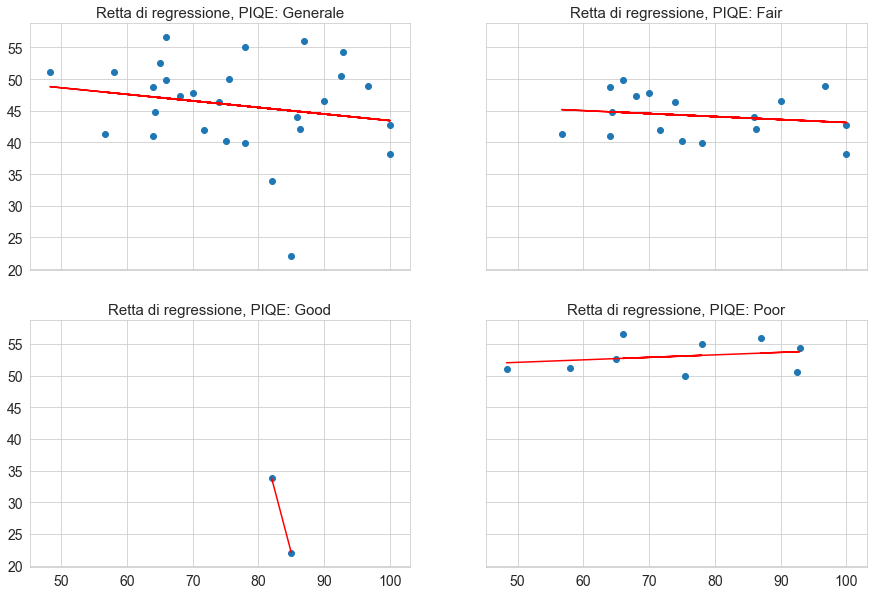

In [20]:
# Creiamo un DataFrame per salvare le metriche
metriche = pd.DataFrame(columns=('index', 'm', 'q', 'r2', 'rmse'))

figure, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(15,10))


for i in range(0, len(dfs)):
    # Creiamo il modello
    lr = LinearRegression()
    
    # Definiamo X e y
    X = dfs[i]['sensitivity'].to_numpy().reshape(-1, 1)
    y = dfs[i]['piqe_val'].to_numpy().reshape(-1, 1)
    
    # Adattiamo il modello ai dati
    lr.fit(X, y)
    
    # Estraiamo m e q dal modello
    m = lr.coef_[0][0]
    q = lr.intercept_[0]
    
    if (i < 2):
        row = 0
        column = i
    else:
        row = 1
        column = i-2
    
    # Diamo un titolo al grafico
    axes[row][column].set_title(f"Retta di regressione, PIQE: {dfs[i]['piqe'].iloc[0]}")
    
    # Creiamo lo scatter plot con i punti
    axes[row][column].scatter(X, y)
    
    # Disegnamo la retta usando la formula
    axes[row][column].plot(X, m*X + q, c='r')
    
    # Calcoliamo qualche metrica
    r2 = lr.score(X, y)
    rmse = mean_squared_error(y, lr.predict(X))**0.5
    
    # Stampiamo un po' di metriche
    metriche = metriche.append({
        'index': dfs[i]['piqe'].iloc[0],
        'm': m,
        'q': q,
        'r2': r2,
        'rmse': rmse
    }, ignore_index=True)

In [26]:
metriche

,index,m,q,r2,rmse
0,Generale,-0.103710,53.813984,0.037139,7.135136e+00
1,Fair,-0.047046,47.842851,0.031299,3.468215e+00
2,Good,-3.936667,356.656667,1.000000,2.131628e-14
3,Poor,0.039339,50.124472,0.060288,2.284580e+00


## Analisi in relazione a disponibilità immagine

In [31]:
# Splittiamo le diverse classi di piqe in tanti dataframe
dfs_2 = [x for _, x in df.groupby('percentual')]

In [46]:
dfs_2

[    percentual  piqe_val  sensitivity  piqe
 0           -1     22.04         85.0  Good
 1           -1     33.85         82.0  Good
 2           -1     38.11        100.0  Fair
 3           -1     39.95         78.0  Fair
 4           -1     41.27         56.7  Fair
 5           -1     41.92         71.7  Fair
 6           -1     42.80        100.0  Fair
 7           -1     46.34         74.0  Fair
 8           -1     46.55         90.0  Fair
 9           -1     47.40         68.0  Fair
 10          -1     48.73         64.0  Fair
 11          -1     48.94         96.7  Fair
 12          -1     49.84         66.0  Fair
 13          -1     51.08         48.3  Poor
 14          -1     51.13         58.0  Poor
 15          -1     52.55         65.0  Poor
 16          -1     55.01         78.0  Poor
 17          -1     56.58         66.0  Poor,
     percentual  piqe_val  sensitivity  piqe
 18           1     40.16         75.0  Fair
 19           1     40.96         64.0  Fair
 20      

In [33]:
dfs_2[0].corr()

,percentual,piqe_val,sensitivity
percentual,NaN,NaN,NaN
piqe_val,NaN,1.000000,-0.411082
sensitivity,NaN,-0.411082,1.000000


In [34]:
dfs_2[1].corr()

,percentual,piqe_val,sensitivity
percentual,NaN,NaN,NaN
piqe_val,NaN,1.000000,0.541261
sensitivity,NaN,0.541261,1.000000


In [51]:
X = dfs_2[0]['sensitivity']
y = dfs_2[0]['piqe_val']
X2 = dfs_2[1]['sensitivity']
y2 = dfs_2[1]['piqe_val']

m = np.cov(X, y, bias=True)[0][1]/np.var(X)
q = np.mean(y) - (m * np.mean(X))
print(f"y = {m:.2f}x + {q:.2f}")

m2 = np.cov(X2, y2, bias=True)[0][1]/np.var(X2)
q2 = np.mean(y2) - (m2 * np.mean(X2))
print(f"y = {m2:.2f}x + {q2:.2f}")

y = -0.23x + 62.17
y = 0.27x + 25.37


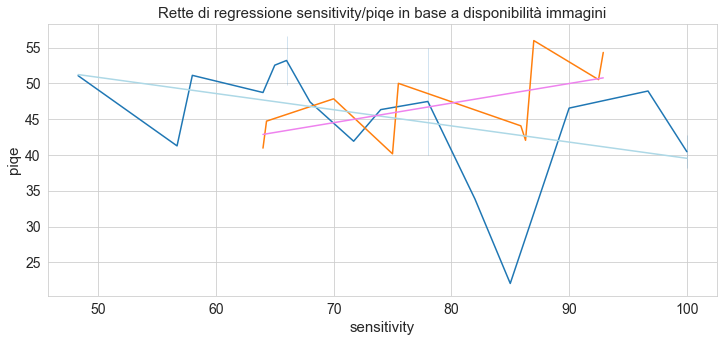

In [80]:
plt.figure(figsize=(12,5))
ax = plt.axes()

# Creiamo lo scatter plot con i punti
sns.lineplot(X, y, axes=ax)
sns.lineplot(X2, y2, axes=ax)

# Disegnamo la retta usando la formula
sns.lineplot(X, m*X + q, color='lightblue', axes=ax)
sns.lineplot(X2, m2*X2 + q2, color='violet', axes=ax)

plt.title('Rette di regressione sensitivity/piqe in base a disponibilità immagini');
plt.ylabel('piqe');
plt.savefig('fig1.png');

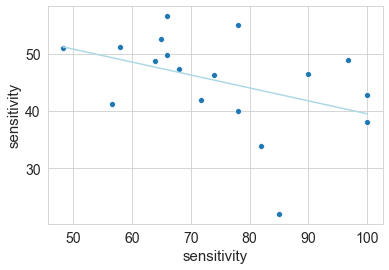

In [71]:
sns.scatterplot(X, y)
sns.lineplot(X, m*X + q, color='lightblue')

In [53]:
dfs_2[0]['y_pred'] = dfs_2[0]['sensitivity'] * m + q
dfs_2[1]['y_pred'] = dfs_2[1]['sensitivity'] * m2 + q2

In [54]:
dfs_2[0].head()

,percentual,piqe_val,sensitivity,piqe,y_pred
0,-1,22.04,85.0,Good,42.930944
1,-1,33.85,82.0,Good,43.610019
2,-1,38.11,100.0,Fair,39.535571
3,-1,39.95,78.0,Fair,44.515451
4,-1,41.27,56.7,Fair,49.336881


In [55]:
dfs_2[1].head()

,percentual,piqe_val,sensitivity,piqe,y_pred
18,1,40.16,75.0,Fair,45.880880
19,1,40.96,64.0,Fair,42.872052
20,1,42.05,86.3,Fair,48.971768
21,1,44.07,85.9,Fair,48.862356
22,1,44.73,64.3,Fair,42.954111


In [67]:
print(r2_score(dfs_2[0]['piqe_val'], dfs_2[0]['y_pred']))
print(mean_squared_error(dfs_2[0]['piqe_val'], dfs_2[0]['y_pred'])**0.5)

0.16898835430212522
7.382231075840893


In [68]:
print(r2_score(dfs_2[1]['piqe_val'], dfs_2[1]['y_pred']))
print(mean_squared_error(dfs_2[1]['piqe_val'], dfs_2[1]['y_pred'])**0.5)

0.29296326452658517
4.435489038466931
